In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
from tqdm.notebook import tqdm

# Group size analysis

In [10]:
calc_factors = lambda x: np.array([i for i in range(1, x+1) if x%i==0])
optim_fn = griewank
n_gen = 500
n_seed = 2
n_dim = 100


# d = np.zeros((len(n_pops), len(optim_fns), len(n_dims), 
#                  len(init_pop_vars), n_seed, n_gen+1, 2))
# d = xr.DataArray(d, dims=('algo', 'optim_fn', 'n_dim', 
#                                 'init_pop_var', 'seed', 'gen', 'fits_mrs'),
#                     coords={'algo': algos, 
#                             'optim_fn': optim_fns,
#                             'n_dim': n_dims,
#                             'init_pop_var': init_pop_vars,
#                             'seed': list(range(n_seed)),
#                             'gen': list(range(n_gen+1)),
#                             'fits_mrs': ['fits', 'mrs'],
#                            })

# n_pops = [51, 101, 201, 401, 601, 801, 1001]
# n_pops = [51, 101, 201, 401, 801, 1601, 3201]
n_pops = [51, 101, 201, 401, 801]
# n_pops = [11, 15]

n_pop2n_mutpops = {n_pop: calc_factors(n_pop-1) for n_pop in n_pops}

n_pop2data = {}
for n_pop in n_pops:
    f = []
    n_mutpops = n_pop2n_mutpops[n_pop]
    print(n_pop, n_mutpops)
    for n_mutpop in tqdm(n_mutpops):
        for seed in range(n_seed):
            do_seed(seed+100)
            pop = torch.randn(n_pop, n_dim)*5
            pops, fits, mrs, _ = optim.run_evolution_ours(pop, optim_fn, n_gen, n_mutpop)
            f.append(fits)
    f = torch.stack(f).reshape(len(n_mutpops), n_seed, n_gen+1, n_pop)
    n_pop2data[n_pop] = f


51 [ 1  2  5 10 25 50]


  0%|          | 0/6 [00:00<?, ?it/s]

101 [  1   2   4   5  10  20  25  50 100]


  0%|          | 0/9 [00:00<?, ?it/s]

201 [  1   2   4   5   8  10  20  25  40  50 100 200]


  0%|          | 0/12 [00:00<?, ?it/s]

401 [  1   2   4   5   8  10  16  20  25  40  50  80 100 200 400]


  0%|          | 0/15 [00:00<?, ?it/s]

801 [  1   2   4   5   8  10  16  20  25  32  40  50  80 100 160 200 400 800]


  0%|          | 0/18 [00:00<?, ?it/s]

In [59]:
torch.save((n_pops, n_pop2n_mutpops, n_pop2data), 'results/data_group_size.th')

In [61]:
n_pops, n_pop2n_mutpops, n_pop2data = torch.load('results/data_group_size.th')

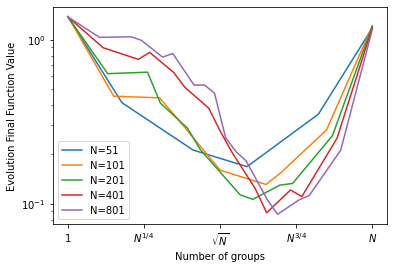

In [11]:
# plt.figure(figsize=(10, 5))
for n_pop in n_pops:
    data = n_pop2data[n_pop]
    n_mutpops = n_pop2n_mutpops[n_pop]
    
    a = data.min(dim=-1).values[..., -1].T
    x = np.exp(np.log(n_mutpops)/np.log(np.max(n_mutpops)))
    plt.plot(x, a.mean(dim=0).numpy(), label=f'N={n_pop}')
    ticks = np.e**np.linspace(0, 1, 5)
    plt.xscale('log')
    plt.gca().set_xticks(ticks)
    plt.gca().set_xticklabels(['$1$', '$N^{1/4}$', '$\sqrt{N}$', '$N^{3/4}$', '$N$'])
    plt.minorticks_off()
    plt.xlabel('Number of groups')
    plt.ylabel('Evolution Final Function Value')
    plt.legend()
plt.yscale('log')
# plt.savefig('results/group_size.png', dpi=300)

plt.show()